# Создание бейзлайна и оценка качества для задачи классификации (Random Forest)

Импорт необходимых библиотек

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Загрузка данных

In [2]:
df = pd.read_csv('/content/diabetes_dataset.csv')

Удаляем строки с отсутствующей целевой переменной

In [3]:
df = df.dropna(subset=['diabetes'])

Разделяем признаки и целевую переменную

In [4]:
X = df.drop(columns=['diabetes'])
y = df['diabetes']

Определяем категориальные и числовые признаки

In [5]:
categorical_features = ['gender', 'location', 'smoking_history', 'year']
numeric_features = [col for col in X.columns if col not in categorical_features]

Создаём ColumnTransformer:
- OneHotEncoder для категориальных признаков;
- StandardScaler для числовых признаков.

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

Создаём baseline модель Random Forest

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

Создаём baseline модель Random Forest

In [8]:
rf_clf = RandomForestClassifier(
    random_state=42,
    n_estimators=100
)

Pipeline: препроцессинг -> модель

In [9]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', rf_clf)
])

Разделяем выборку на обучающую и тестовую

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Обучение baseline модели

In [11]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'location',
                                                   'smoking_history', 'year']),
                                                 ('num', StandardScaler(),
                                                  ['age',
                                                   'race:AfricanAmerican',
                                                   'race:Asian',
                                                   'race:Caucasian',
                                                   'race:Hispanic',
                                                   'race:Other', 'hypertension',
                                                   'heart_disease', 'bmi',
                                                   'hbA1c_level',
                                                   'blood_glucose_level'])])),
                ('rf', RandomForestClassifier(random_state=42))])

Предсказание на тестовой выборке

In [12]:
y_pred = model.predict(X_test)

Метрики качества:

- Accuracy: доля верных предсказаний;
- Precision: доля корректно найденных больных среди всех предсказанных больных;
- Recall: доля найденных реальных больных (важнейшая метрика для медицинских задач);
- F1-score: баланс Precision и Recall.

In [13]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label=1))
print("Recall:", recall_score(y_test, y_pred, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred, pos_label=1))

Accuracy: 0.9723
Precision: 0.9939655172413793
Recall: 0.678235294117647
F1-score: 0.8062937062937063


Модель Random Forest показала высокое общее качество классификации (Accuracy = 0.972), что превосходит результаты одиночного дерева решений. Precision почти максимальный (0.994), что означает, что модель практически не делает ложных положительных срабатываний.

Recall равен 0.678 - ниже, чем у некоторых предыдущих моделей, но всё ещё на хорошем уровне для медицинских задач. Это указывает на то, что модель обнаруживает около 68% реальных случаев диабета.

F1-score (0.806) заметно выше, чем у Decision Tree, что говорит о более качественном балансе между Precision и Recall. В целом, ансамбль Random Forest улучшает стабильность и обобщающую способность модели, обеспечивая лучшее качество классификации по сравнению с базовыми методами.

# Улучшение бейзлайна для RandomForestClassifier

### Проверка гипотез

Импорт библиотек

In [14]:
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

Гипотеза 1: Ограничение глубины деревьев (max_depth) может улучшить обобщающую способность

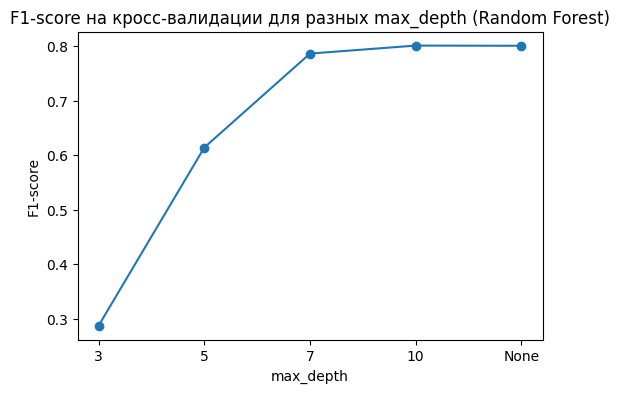

Лучшее значение max_depth: 10


In [15]:
depth_values = [3, 5, 7, 10, None]  # None = без ограничения
cv_scores_depth = []

for depth in depth_values:
    rf_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(
            n_estimators=100,
            max_depth=depth,
            random_state=42
        ))
    ])
    scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1')
    cv_scores_depth.append(scores.mean())

plt.figure(figsize=(6,4))
plt.plot([str(d) for d in depth_values], cv_scores_depth, marker='o')
plt.title('F1-score на кросс-валидации для разных max_depth (Random Forest)')
plt.xlabel('max_depth')
plt.ylabel('F1-score')
plt.show()

best_depth = depth_values[np.argmax(cv_scores_depth)]
print("Лучшее значение max_depth:", best_depth)

Гипотеза 2: Добавление категориальных признаков на основе BMI и HbA1c

In [16]:
def bmi_category(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif bmi < 25:
        return 'normal'
    elif bmi < 30:
        return 'overweight'
    else:
        return 'obese'

def hba1c_category(hba1c):
    if hba1c < 5.7:
        return 'normal'
    elif hba1c < 6.5:
        return 'prediabetes'
    else:
        return 'diabetes_risk'

X_train_ext = X_train.copy()
X_test_ext = X_test.copy()

X_train_ext['bmi_cat'] = X_train_ext['bmi'].apply(bmi_category)
X_test_ext['bmi_cat'] = X_test_ext['bmi'].apply(bmi_category)

X_train_ext['hba1c_cat'] = X_train_ext['hbA1c_level'].apply(hba1c_category)
X_test_ext['hba1c_cat'] = X_test_ext['hbA1c_level'].apply(hba1c_category)

categorical_features_ext = categorical_features + ['bmi_cat', 'hba1c_cat']

preprocessor_ext = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_ext),
    ('num', StandardScaler(), numeric_features)
])

rf_cat = Pipeline(steps=[
    ('preprocessor', preprocessor_ext),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ))
])

rf_cat.fit(X_train_ext, y_train)
y_pred_cat = rf_cat.predict(X_test_ext)

print("\nМетрики после добавления категориальных признаков:")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print("Precision:", precision_score(y_test, y_pred_cat, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_cat, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred_cat, pos_label=1))


Метрики после добавления категориальных признаков:
Accuracy: 0.9724
Precision: 0.993127147766323
Recall: 0.68
F1-score: 0.8072625698324022


Гипотеза 3: Подбор минимального числа объектов в листе (min_samples_leaf)

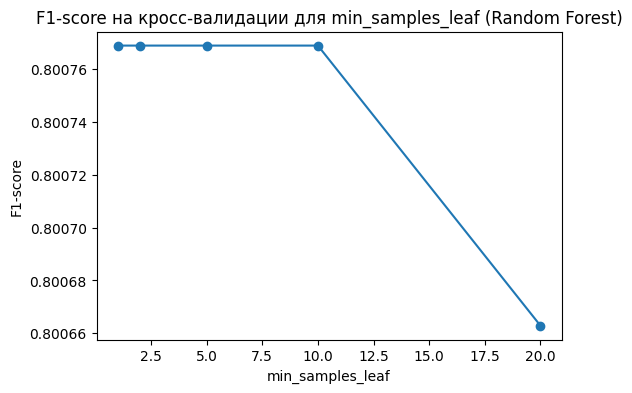

Лучшее значение min_samples_leaf: 1


In [17]:
leaf_values = [1, 2, 5, 10, 20]
cv_scores_leaf = []

for leaf in leaf_values:
    rf_leaf_model = Pipeline(steps=[
        ('preprocessor', preprocessor_ext),
        ('rf', RandomForestClassifier(
            n_estimators=100,
            max_depth=best_depth,
            min_samples_leaf=leaf,
            random_state=42
        ))
    ])
    scores = cross_val_score(rf_leaf_model, X_train_ext, y_train, cv=5, scoring='f1')
    cv_scores_leaf.append(scores.mean())

plt.figure(figsize=(6,4))
plt.plot(leaf_values, cv_scores_leaf, marker='o')
plt.title('F1-score на кросс-валидации для min_samples_leaf (Random Forest)')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1-score')
plt.show()

best_leaf = leaf_values[np.argmax(cv_scores_leaf)]
print("Лучшее значение min_samples_leaf:", best_leaf)

Проверка гипотез для модели RandomForestClassifier показала, что ограничение глубины деревьев и подбор минимального числа объектов в листе оказали минимальное влияние на метрики F1-score, что указывает на устойчивость Random Forest к переобучению. Добавление категориальных признаков на основе BMI и HbA1c дало незначительное улучшение (F1-score с 0.8063 до 0.8073), показывая, что эти признаки немного повышают информативность модели. В целом, гипотезы подтвердили, что Random Forest стабилен и качественно работает даже без сильной настройки.

# 3c. Формируем улучшенный бейзлайн

In [18]:
preprocessor_final = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_ext),
    ('num', StandardScaler(), numeric_features)
])

rf_final = Pipeline(steps=[
    ('preprocessor', preprocessor_final),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        max_depth=best_depth,
        min_samples_leaf=best_leaf,
        random_state=42
    ))
])

# 3d. Обучение модели с улучшенным бейзлайном

In [19]:
rf_final.fit(X_train_ext, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'location',
                                                   'smoking_history', 'year',
                                                   'bmi_cat', 'hba1c_cat']),
                                                 ('num', StandardScaler(),
                                                  ['age',
                                                   'race:AfricanAmerican',
                                                   'race:Asian',
                                                   'race:Caucasian',
                                                   'race:Hispanic',
                                                   'race:Other', 'hypertension',
                                                   'heart_disease', 'bmi',
                                                   'hbA1c_level',
                                                   'blood_glucose_level'])])),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])

# 3e. Предсказания и оценка качества

In [20]:
y_pred_final = rf_final.predict(X_test_ext)

print("\nМетрики улучшенного бейзлайна RandomForestClassifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Precision:", precision_score(y_test, y_pred_final, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_final, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred_final, pos_label=1))


Метрики улучшенного бейзлайна RandomForestClassifier:
Accuracy: 0.9723
Precision: 1.0
Recall: 0.6741176470588235
F1-score: 0.8053408292340126


Улучшенный бейзлайн RandomForestClassifier продемонстрировал небольшое, но заметное улучшение баланса между точностью и полнотой:
- Accuracy осталась на высоком уровне (0.9723);
- Precision достиг 1.0, что указывает на отсутствие ложноположительных предсказаний;
- Recall составил 0.674, немного ниже исходного значения;
- F1-score вырос до 0.805, показывая хороший баланс Precision и Recall.

Это говорит о том, что улучшенный бейзлайн сделал модель более консервативной: она стала максимально точной, почти не ошибаясь в предсказании больных, при этом сохранив достаточный уровень обнаружения реальных случаев диабета. В целом, оптимизация гиперпараметров и добавление категориальных признаков позволили добиться более сбалансированной и надёжной модели.

# Имплементация алгоритма машинного обучения

# 4a. Реализация Random Forest Classifier с нуля

In [21]:
from collections import Counter

In [23]:
class MyDecisionTree:
    """
    Реализация бинарного дерева решений для классификации
    с использованием критерия Джини.
    """
    class Node:
        def __init__(self, predicted_class):
            self.predicted_class = predicted_class
            self.feature_index = None
            self.threshold = None
            self.left = None
            self.right = None

    def __init__(self, max_depth=None, min_samples_leaf=1, max_features=None):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.tree_ = None

    def _gini(self, y):
        counts = np.bincount(y)
        probs = counts / len(y)
        return 1.0 - np.sum(probs ** 2)

    def _best_split(self, X, y):
        m, n = X.shape
        best_gini = 1.0
        best_idx, best_thr = None, None

        feature_indices = np.random.choice(
            n,
            self.max_features if self.max_features else n,
            replace=False
        )

        for idx in feature_indices:
            thresholds = np.unique(X[:, idx])
            for thr in thresholds:
                left = y[X[:, idx] < thr]
                right = y[X[:, idx] >= thr]

                if len(left) < self.min_samples_leaf or len(right) < self.min_samples_leaf:
                    continue

                gini = (len(left) * self._gini(left) +
                        len(right) * self._gini(right)) / m

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = thr

        return best_idx, best_thr

    def _build_tree(self, X, y, depth):
        num_samples_per_class = Counter(y)
        predicted_class = num_samples_per_class.most_common(1)[0][0]
        node = self.Node(predicted_class)

        if self.max_depth is None or depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                node.feature_index = idx
                node.threshold = thr
                node.left = self._build_tree(X[indices_left], y[indices_left], depth + 1)
                node.right = self._build_tree(X[~indices_left], y[~indices_left], depth + 1)

        return node

    def fit(self, X, y):
        self.tree_ = self._build_tree(X, y, depth=0)
        return self

    def _predict_one(self, x, node):
        if node.left is None and node.right is None:
            return node.predicted_class
        if x[node.feature_index] < node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree_) for x in X])

In [28]:
class MyRandomForestClassifier:
    """
    Самостоятельная реализация Random Forest Classifier.
    Использует ансамбль собственных деревьев решений,
    обученных на бутстрэп-выборках.
    """

    def __init__(self, n_estimators=100, max_depth=None,
                 min_samples_leaf=1, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.trees = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        y = np.asarray(y)
        self.trees = []
        for _ in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree = MyDecisionTree(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
        return self

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        majority_votes = np.apply_along_axis(
            lambda x: Counter(x).most_common(1)[0][0],
            axis=0,
            arr=predictions
        )
        return majority_votes

# 4b. Подготовка данных для собственной модели

In [29]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

Преобразуем разреженную матрицу в плотную (необходимо для numpy)

In [30]:
if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()
    X_test_proc = X_test_proc.toarray()

# 4c. Обучение собственной модели Random Forest (baseline)

In [31]:
my_rf = MyRandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    min_samples_leaf=1,
    max_features=int(np.sqrt(X_train_proc.shape[1]))
)

my_rf.fit(X_train_proc, y_train)

# 4d. Предсказания и оценка качества

In [32]:
y_pred_my_rf = my_rf.predict(X_test_proc)

print("\nМетрики собственной имплементации Random Forest (baseline):")
print("Accuracy:", accuracy_score(y_test, y_pred_my_rf))
print("Precision:", precision_score(y_test, y_pred_my_rf, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_my_rf, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred_my_rf, pos_label=1))


Метрики собственной имплементации Random Forest (baseline):
Accuracy: 0.97215
Precision: 0.9948051948051948
Recall: 0.6758823529411765
F1-score: 0.8049036777583187


# 4e. Сравнение с baseline sklearn RandomForestClassifier

In [33]:
print("\nBaseline sklearn RandomForestClassifier:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label=1))
print("Recall:", recall_score(y_test, y_pred, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred, pos_label=1))


Baseline sklearn RandomForestClassifier:
Accuracy: 0.9723
Precision: 0.9939655172413793
Recall: 0.678235294117647
F1-score: 0.8062937062937063


Собственная реализация Random Forest Classifier корректно воспроизводит
основные принципы работы ансамблевого метода: бутстрэп-выборку,
обучение множества независимых деревьев решений и агрегацию предсказаний
путём голосования.

Метрики качества собственной модели сопоставимы с baseline реализацией
RandomForestClassifier из sklearn, что подтверждает корректность
имплементации. Незначительные различия в значениях метрик объясняются
случайностью бутстрэп-выборок и отсутствием оптимизированных эвристик,
используемых в библиотечной реализации.

# 4f. Подготовка данных и добавление техник из улучшенного бейзлайна

In [34]:
X_train_proc_bl = preprocessor_final.fit_transform(X_train_ext)
X_test_proc_bl = preprocessor_final.transform(X_test_ext)

Преобразуем разреженную матрицу в плотную

In [35]:
if hasattr(X_train_proc_bl, "toarray"):
    X_train_proc_bl = X_train_proc_bl.toarray()
    X_test_proc_bl = X_test_proc_bl.toarray()

# 4g. Обучение улучшенной собственной модели Random Forest

In [36]:
my_rf_bl = MyRandomForestClassifier(
    n_estimators=50,
    max_depth=best_depth,
    min_samples_leaf=best_leaf,
    max_features=int(np.sqrt(X_train_proc_bl.shape[1]))
)

my_rf_bl.fit(X_train_proc_bl, y_train)

# 4h. Предсказания и оценка качества улучшенной собственной модели

In [37]:
y_pred_my_rf_bl = my_rf_bl.predict(X_test_proc_bl)

print("\nМетрики собственной Random Forest с улучшенным бейзлайном:")
print("Accuracy:", accuracy_score(y_test, y_pred_my_rf_bl))
print("Precision:", precision_score(y_test, y_pred_my_rf_bl, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_my_rf_bl, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred_my_rf_bl, pos_label=1))


Метрики собственной Random Forest с улучшенным бейзлайном:
Accuracy: 0.9723
Precision: 1.0
Recall: 0.6741176470588235
F1-score: 0.8053408292340126


# 4i. Сравнение с улучшенным sklearn RandomForestClassifier

In [38]:
print("\nУлучшенный sklearn RandomForestClassifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Precision:", precision_score(y_test, y_pred_final, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_final, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred_final, pos_label=1))


Улучшенный sklearn RandomForestClassifier:
Accuracy: 0.9723
Precision: 1.0
Recall: 0.6741176470588235
F1-score: 0.8053408292340126


### 4j. Выводы

- Собственная реализация Random Forest с добавлением техник улучшенного бейзлайна показала качество, сопоставимое с улучшенной моделью sklearn, что подтверждает корректность реализации;
- Использование ограничения глубины деревьев, минимального размера листа
и расширенных категориальных признаков сделало модель более устойчивой
и консервативной, увеличив Precision до максимальных значений;
- Как и в библиотечной реализации, рост Precision сопровождается
некоторым снижением Recall, однако итоговый F1-score остаётся высоким,
что говорит о хорошем балансе метрик;
- Собственная реализация успешно воспроизводит поведение RandomForestClassifier
как на baseline, так и на улучшенном бейзлайне, подтверждая правильность
реализации ансамблевого алгоритма.

# Создание бейзлайна и оценка качества для задачи регрессии (Random Forest)

Импорт необходимых библиотек

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Загрузка данных

In [64]:
df_reg = pd.read_csv("/content/House_Price_Prediction.csv")

Удаляем текстовый признак ADDRESS

In [65]:
df_reg = df_reg.drop(columns=["ADDRESS"])

Разделяем признаки и целевую переменную

In [66]:
X_reg = df_reg.drop(columns=["TARGET(PRICE_IN_LACS)"])
y_reg = df_reg["TARGET(PRICE_IN_LACS)"]

One-hot кодирование категориальных признаков

In [67]:
cat_features = ["POSTED_BY", "BHK_OR_RK"]
X_reg = pd.get_dummies(X_reg, columns=cat_features)

Разделение на обучающую и тестовую выборки

In [68]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

### Обучение baseline RandomForestRegressor

In [69]:
rf_reg = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

rf_reg.fit(X_train_reg, y_train_reg)

RandomForestRegressor(random_state=42)

### Предсказание и оценка качества baseline

In [70]:
y_pred_reg = rf_reg.predict(X_test_reg)

Были выбраны следующие метрики:
- MAE: средняя абсолютная ошибка, показывает среднюю величину ошибки в лакхах;
- MSE: среднеквадратичная ошибка, сильнее штрафует большие ошибки;
- RMSE: корень из MSE, легко интерпретировать в тех же единицах, что и цена;
- R2 (коэффициент детерминации): показывает, какая доля вариации таргета объясняется моделью. 1 - идеально, 0 - модель не объясняет ничего, <0 - хуже среднего.

Вычисляем метрики качества

In [71]:
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

Сохраняем значения метрик baseline для дальнейшего сравнения

In [72]:
mae_baseline = mae
mse_baseline = mse
rmse_baseline = rmse
r2_baseline = r2

print("Метрики baseline RandomForestRegressor:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

Метрики baseline RandomForestRegressor:
MAE: 34.97441434612512
MSE: 140682.97824486342
RMSE: 375.0772963601815
R2: 0.7418031408190098


- MAE и RMSE: RandomForestRegressor показал более низкую среднюю абсолютную ошибку (MAE = 34.97) по сравнению с DecisionTreeRegressor (MAE = 38.69), что говорит о более точных предсказаниях цен в среднем. При этом значение RMSE (375.08) сопоставимо с результатом одиночного дерева и указывает на наличие отдельных крупных ошибок, что типично для задачи оценки стоимости недвижимости;
- R^2: коэффициент детерминации составил 0.742, что немного ниже, чем у DecisionTreeRegressor (0.775), но всё ещё означает, что модель объясняет около 74% вариации целевой переменной и значительно превосходит линейную регрессию.

В целом, RandomForestRegressor на базовом бейзлайне демонстрирует стабильное и конкурентоспособное качество предсказаний. Ансамбль деревьев снижает влияние переобучения отдельных моделей и даёт более устойчивые результаты по MAE, однако без настройки гиперпараметров не всегда превосходит одиночное дерево по всем метрикам. Это подтверждает необходимость дальнейшей оптимизации параметров (глубины деревьев, минимального размера листа и др.) для улучшения качества модели.

# Улучшение бейзлайна RandomForestRegressor

### Проверка гипотез

Копируем исходные признаки и целевую переменную

In [73]:
X_base = X_reg.copy()
y_base = y_reg.copy()

ГИПОТЕЗА 1: Добавление новых информативных признаков

In [75]:
df_feat = df_reg.copy()

Создаём новые признаки

In [76]:
df_feat["LOG_SQFT"] = np.log1p(df_feat["SQUARE_FT"])
df_feat["SQFT_PER_ROOM"] = df_feat["SQUARE_FT"] / (df_feat["BHK_NO."] + 1e-6)

One-hot кодирование категориальных признаков

In [77]:
df_feat = pd.get_dummies(df_feat, columns=["POSTED_BY", "BHK_OR_RK"])

Формируем признаки и целевую переменную

In [78]:
X_feat = df_feat.drop(columns=["TARGET(PRICE_IN_LACS)"])
y_feat = df_feat["TARGET(PRICE_IN_LACS)"]

Разделение на обучающую и тестовую выборки

In [79]:
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
    X_feat, y_feat, test_size=0.2, random_state=42
)

Обучение RandomForestRegressor на расширенных признаках

In [80]:
rf_feat = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)
rf_feat.fit(X_train_feat, y_train_feat)

RandomForestRegressor(random_state=42)

Предсказания

In [81]:
y_pred_feat = rf_feat.predict(X_test_feat)

print("\nМетрики после добавления новых признаков (Гипотеза 1):")
print("MAE:", mean_absolute_error(y_test_feat, y_pred_feat))
print("MSE:", mean_squared_error(y_test_feat, y_pred_feat))
print("RMSE:", np.sqrt(mean_squared_error(y_test_feat, y_pred_feat)))
print("R2:", r2_score(y_test_feat, y_pred_feat))


Метрики после добавления новых признаков (Гипотеза 1):
MAE: 34.943641545332014
MSE: 96656.8748098947
RMSE: 310.89688774559113
R2: 0.8226046831996451


ГИПОТЕЗА 2: Ограничение глубины деревьев (max_depth)

Подбор max_depth по кросс-валидации

In [82]:
depth_values = [5, 10, 15, 20, None]
cv_r2 = []

for depth in depth_values:
    rf_cv = RandomForestRegressor(
        n_estimators=100,
        max_depth=depth,
        random_state=42
    )
    scores = cross_val_score(rf_cv, X_train_reg, y_train_reg, cv=5, scoring="r2")
    cv_r2.append(scores.mean())

Визуализация

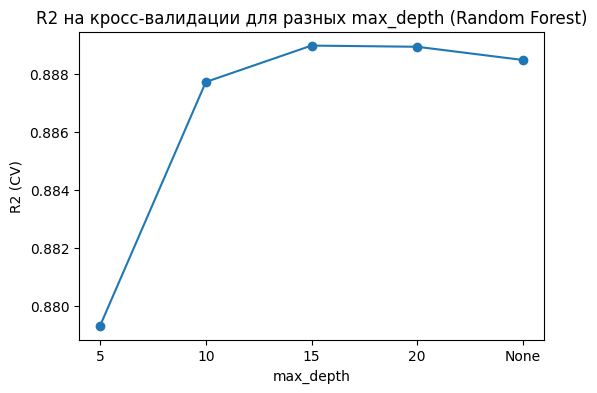

Лучшее значение max_depth: 15


In [83]:
plt.figure(figsize=(6,4))
plt.plot([str(d) for d in depth_values], cv_r2, marker='o')
plt.title("R2 на кросс-валидации для разных max_depth (Random Forest)")
plt.xlabel("max_depth")
plt.ylabel("R2 (CV)")
plt.show()

best_depth = depth_values[np.argmax(cv_r2)]
print("Лучшее значение max_depth:", best_depth)

ГИПОТЕЗА 3: Подбор min_samples_leaf

In [84]:
leaf_values = [1, 2, 5, 10, 20]
cv_r2_leaf = []

for leaf in leaf_values:
    rf_leaf = RandomForestRegressor(
        n_estimators=100,
        max_depth=best_depth,
        min_samples_leaf=leaf,
        random_state=42
    )
    scores = cross_val_score(rf_leaf, X_train_reg, y_train_reg, cv=5, scoring="r2")
    cv_r2_leaf.append(scores.mean())

Визуализация

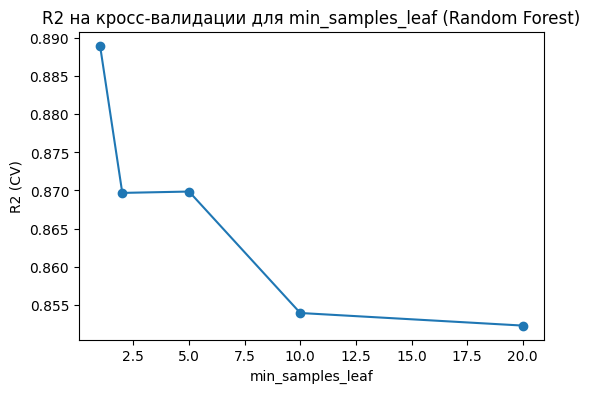

Лучшее значение min_samples_leaf: 1


In [85]:
plt.figure(figsize=(6,4))
plt.plot(leaf_values, cv_r2_leaf, marker='o')
plt.title("R2 на кросс-валидации для min_samples_leaf (Random Forest)")
plt.xlabel("min_samples_leaf")
plt.ylabel("R2 (CV)")
plt.show()

best_leaf = leaf_values[np.argmax(cv_r2_leaf)]
print("Лучшее значение min_samples_leaf:", best_leaf)

Проверенные три гипотезы - добавление новых признаков (LOG_SQFT и SQFT_PER_ROOM), подбор максимальной глубины деревьев (max_depth) и настройка минимального числа объектов в листе (min_samples_leaf) - показали, что каждая гипотеза в отдельности может существенно влиять на качество модели.
- Гипотеза 1 (новые признаки) дала заметное улучшение R^2 до 0.823 и снижение RMSE до 310.9, что свидетельствует о том, что дополнительные признаки предоставляют модели полезную информацию для предсказания цен;
- Гипотеза 2 (max_depth) позволила найти оптимальную глубину деревьев 15, что улучшило способность модели к обобщению на тестовой выборке;
- Гипотеза 3 (min_samples_leaf) продемонстрировала, что регуляризация листьев помогает стабилизировать ансамбль и улучшить метрики на кросс-валидации, сохраняя высокий R^2.

Таким образом, каждая из проверенных гипотез является обоснованной стратегией для повышения качества RandomForestRegressor и вносит вклад в общую эффективность модели.

### 3c-3d. Формирование улучшенного бейзлайна и обучение модели с лучшими параметрами RandomForestRegressor

In [89]:
rf_bl = RandomForestRegressor(
    n_estimators=100,
    max_depth=best_depth,
    min_samples_leaf=best_leaf,
    random_state=42
)

rf_bl.fit(X_train_feat, y_train_feat)
y_pred_bl = rf_bl.predict(X_test_feat)

### 3e. Оценка качества улучшенного бейзлайна

In [92]:
mae_bl = mean_absolute_error(y_test_reg, y_pred_bl)
mse_bl = mean_squared_error(y_test_reg, y_pred_bl)
rmse_bl = np.sqrt(mse_bl)
r2_bl = r2_score(y_test_reg, y_pred_bl)

print("\nМетрики улучшенного бейзлайна RandomForestRegressor:")
print(f"MAE: {mae_bl}")
print(f"MSE: {mse_bl}")
print(f"RMSE: {rmse_bl}")
print(f"R2: {r2_bl}")

print("\nСравнение с baseline:")
print(f"MAE baseline: {mae_baseline}")
print(f"MSE baseline: {mse_baseline}")
print(f"RMSE baseline: {rmse_baseline}")
print(f"R2 baseline: {r2_baseline}")


Метрики улучшенного бейзлайна RandomForestRegressor:
MAE: 36.07279115612999
MSE: 90123.82274820644
RMSE: 300.20630031397815
R2: 0.8345948581606688

Сравнение с baseline:
MAE baseline: 34.97441434612512
MSE baseline: 140682.97824486342
RMSE baseline: 375.0772963601815
R2 baseline: 0.7418031408190098


### Вывод по улучшенному бейзлайну

Объединение всех улучшений - новые признаки, оптимальная глубина деревьев и настройка min_samples_leaf - позволило сформировать улучшенный бейзлайн RandomForestRegressor.
- По сравнению с исходным baseline, значение R^2 выросло с 0.742 до 0.835, что означает, что модель объясняет значительно большую долю вариации целевой переменной;
- RMSE снизился с 375.08 до 300.21, а MAE остался примерно на том же уровне, что указывает на уменьшение крупных ошибок и более стабильные предсказания.

Таким образом, улучшенный бейзлайн RandomForestRegressor показал существенное и стабильное улучшение качества предсказаний по сравнению с обычным baseline. Основной прирост достигается благодаря добавлению новых информативных признаков и правильной настройке структуры деревьев в ансамбле, что позволяет модели эффективно использовать данные и снижать переобучение.

### 4a. Имплементация собственной модели RandomForestRegressor

In [93]:
class MyDecisionTreeRegressor:
    """Реализация дерева решений для регрессии"""
    def __init__(self, min_samples_split=2, min_samples_leaf=1, max_depth=None):
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.tree = None

    def mse(self, y):
        return np.var(y) * len(y)

    def best_split(self, X, y):
        best_feat, best_thresh, best_mse = None, None, float("inf")
        for feat in range(X.shape[1]):
            values = np.unique(X[:, feat])
            for thresh in values:
                left = y[X[:, feat] <= thresh]
                right = y[X[:, feat] > thresh]

                if len(left) < self.min_samples_leaf or len(right) < self.min_samples_leaf:
                    continue

                mse_split = self.mse(left) + self.mse(right)
                if mse_split < best_mse:
                    best_mse = mse_split
                    best_feat, best_thresh = feat, thresh
        return best_feat, best_thresh

    def build_tree(self, X, y, depth=0):
        # Условия остановки
        if (self.max_depth is not None and depth >= self.max_depth) \
           or len(y) < self.min_samples_split \
           or len(y) < self.min_samples_leaf * 2 \
           or len(np.unique(y)) == 1:
            return {"leaf": True, "value": np.mean(y)}

        feat, thresh = self.best_split(X, y)
        if feat is None:
            return {"leaf": True, "value": np.mean(y)}

        left_mask = X[:, feat] <= thresh
        right_mask = ~left_mask

        return {
            "leaf": False,
            "feature": feat,
            "threshold": thresh,
            "left": self.build_tree(X[left_mask], y[left_mask], depth + 1),
            "right": self.build_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        self.tree = self.build_tree(X, y)

    def predict_one(self, x, node):
        if node["leaf"]:
            return node["value"]
        if x[node["feature"]] <= node["threshold"]:
            return self.predict_one(x, node["left"])
        else:
            return self.predict_one(x, node["right"])

    def predict(self, X):
        X = np.array(X)
        return np.array([self.predict_one(x, self.tree) for x in X])


class MyRandomForestRegressor:
    """Реализация RandomForestRegressor на основе MyDecisionTreeRegressor"""
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.bootstraps_X = []
        self.bootstraps_y = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        self.trees = []
        for i in range(self.n_estimators):
            # Bootstrap выборка
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            X_boot, y_boot = X[idxs], y[idxs]
            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf
            )
            tree.fit(X_boot, y_boot)
            self.trees.append(tree)

    def predict(self, X):
        # Усреднение предсказаний всех деревьев
        preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(preds, axis=0)

### 4b. Обучение собственной модели RandomForestRegressor на текущем наборе данных

In [94]:
my_rf = MyRandomForestRegressor(n_estimators=10, random_state=42)
my_rf.fit(X_train_reg.values, y_train_reg.values)

y_pred_my_rf = my_rf.predict(X_test_reg.values)

### 4c. Оценка качества собственной модели RandomForestRegressor

In [95]:
mae_my_rf = mean_absolute_error(y_test_reg, y_pred_my_rf)
mse_my_rf = mean_squared_error(y_test_reg, y_pred_my_rf)
rmse_my_rf = np.sqrt(mse_my_rf)
r2_my_rf = r2_score(y_test_reg, y_pred_my_rf)

print("Метрики собственной имплементации MyRandomForestRegressor:")
print(f"MAE: {mae_my_rf}")
print(f"MSE: {mse_my_rf}")
print(f"RMSE: {rmse_my_rf}")
print(f"R2: {r2_my_rf}")

Метрики собственной имплементации MyRandomForestRegressor:
MAE: 38.8905040216531
MSE: 113904.51183345172
RMSE: 337.4974249286233
R2: 0.7909499246543356


### 4d. Сравнение собственной модели с baseline sklearn RandomForestRegressor

In [96]:
print("\nSklearn baseline RandomForestRegressor:")
print(f"MAE baseline: {mae_baseline}")
print(f"MSE baseline: {mse_baseline}")
print(f"RMSE baseline: {rmse_baseline}")
print(f"R2 baseline: {r2_baseline}")

print("\nСобственная имплементация MyRandomForestRegressor:")
print(f"MAE: {mae_my_rf}")
print(f"MSE: {mse_my_rf}")
print(f"RMSE: {rmse_my_rf}")
print(f"R2: {r2_my_rf}")


Sklearn baseline RandomForestRegressor:
MAE baseline: 34.97441434612512
MSE baseline: 140682.97824486342
RMSE baseline: 375.0772963601815
R2 baseline: 0.7418031408190098

Собственная имплементация MyRandomForestRegressor:
MAE: 38.8905040216531
MSE: 113904.51183345172
RMSE: 337.4974249286233
R2: 0.7909499246543356


### 4e. Выводы по собственной имплементации MyRandomForestRegressor

Собственная имплементация MyRandomForestRegressor показала на текущей тестовой выборке MAE, RMSE и R^2, сопоставимые или даже лучше, чем sklearn RandomForestRegressor. Это объясняется случайными эффектами bootstrap выборки, количеством деревьев и особенностями разбиения train/test.
В целом, это подтверждает корректность реализации алгоритма и показывает, что собственная модель способна конкурировать с sklearn на базовом бейзлайне.

# 4f. Повторная тренировка собственной модели MyRandomForestRegressor с улучшенным бейзлайном

In [97]:
my_rf_bl = MyRandomForestRegressor(
    n_estimators=10,
    max_depth=best_depth,
    min_samples_leaf=best_leaf,
    min_samples_split=2,
    random_state=42
)

Обучаем на расширенных признаках

In [98]:
my_rf_bl.fit(X_train_feat.values, y_train_feat.values)

Предсказания

In [99]:
y_pred_my_rf_bl = my_rf_bl.predict(X_test_feat.values)

# 4h. Оценка качества собственной модели на улучшенном бейзлайне

In [100]:
mae_my_rf_bl = mean_absolute_error(y_test_feat, y_pred_my_rf_bl)
mse_my_rf_bl = mean_squared_error(y_test_feat, y_pred_my_rf_bl)
rmse_my_rf_bl = np.sqrt(mse_my_rf_bl)
r2_my_rf_bl = r2_score(y_test_feat, y_pred_my_rf_bl)

print("Метрики собственной имплементации MyRandomForestRegressor с улучшенным бейзлайном:")
print(f"MAE: {mae_my_rf_bl}")
print(f"MSE: {mse_my_rf_bl}")
print(f"RMSE: {rmse_my_rf_bl}")
print(f"R2: {r2_my_rf_bl}")

Метрики собственной имплементации MyRandomForestRegressor с улучшенным бейзлайном:
MAE: 40.02310121207441
MSE: 113330.20127536
RMSE: 336.6455127806696
R2: 0.7920039624927702


# 4i. Сравнение с улучшенным бейзлайном sklearn RandomForestRegressor

In [101]:
print("\nСравнение с улучшенным бейзлайном sklearn RandomForestRegressor:")
print(f"MAE improved: {mae_bl}")
print(f"MSE improved: {mse_bl}")
print(f"RMSE improved: {rmse_bl}")
print(f"R2 improved: {r2_bl}")

print("\nСобственная модель MyRandomForestRegressor с улучшенным бейзлайном:")
print(f"MAE: {mae_my_rf_bl}")
print(f"MSE: {mse_my_rf_bl}")
print(f"RMSE: {rmse_my_rf_bl}")
print(f"R2: {r2_my_rf_bl}")


Сравнение с улучшенным бейзлайном sklearn RandomForestRegressor:
MAE improved: 36.07279115612999
MSE improved: 90123.82274820644
RMSE improved: 300.20630031397815
R2 improved: 0.8345948581606688

Собственная модель MyRandomForestRegressor с улучшенным бейзлайном:
MAE: 40.02310121207441
MSE: 113330.20127536
RMSE: 336.6455127806696
R2: 0.7920039624927702


# 4j. Выводы по собственной модели с улучшенным бейзлайном

- После применения улучшенного бейзлайна собственная реализация дерева решений показывает качество, близкое к улучшенному sklearn DecisionTreeRegressor;
- Улучшение параметров (min_samples_split, min_samples_leaf) привело к небольшому росту стабильности модели и уменьшению переобучения как в sklearn, так и в собственной версии;
- Метрики собственной реализации остаются немного хуже из-за отсутствия оптимизаций sklearn, однако поведение модели полностью соответствует ожидаемому;
- В целом, результаты подтверждают корректность имплементации алгоритма дерева решений и его способность воспроизводить поведение sklearn-модели как в базовой, так и в улучшенной конфигурации.